In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.datapath import model_ready_data_paths

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

metric = metrics["weighted_median"]
metric_pct_chg = metric + "_pct_chg"

In [3]:
df = pd.read_csv(model_ready_data_paths["sequence"])

In [4]:
divide_year = 2020 # test_years = [2021]
train_df = df[df["year"] <= divide_year]
test_df = df[df["year"] > divide_year]

In [5]:
note = """
From: https://www.tensorflow.org/tutorials/structured_data/time_series
It's also arguable that the model shouldn't have access to future values in the training set when training, 
and that this normalization should be done using moving averages. 
That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.
"""

# group by area or prefecture to get the mean values for each area
# also do moving averages - this would mean we don't have to do normalization separately

# train_mean = train_df.groupby(by=["area_code"]).mean()
# train_std = train_df.groupby(by=["area_code"]).std()

# train_df = (train_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [6]:
train_df

,unit_price_wmedian_pct_chg,unit_price_wmedian,year,count,total_traded_area,population,taxpayer_count,taxable_income,new_dwellings,existing_dwellings,net_migration_ratio,area_code
0,-0.426053,60214.176441,2010,51.0,13245.0,61910.0,28498.0,84985921.0,303.0,21618.0,0.001454,23232
1,-0.087079,54970.760234,2011,43.0,10190.0,62000.0,28201.0,83968484.0,278.0,21921.0,-0.003113,23232
2,0.389261,76368.729310,2012,42.0,9930.0,61807.0,28324.0,84092410.0,323.0,22199.0,0.000712,23232
3,-0.231734,58671.468587,2013,36.0,9640.0,61851.0,28431.0,84167309.0,257.0,22522.0,-0.002280,23232
4,-0.260870,43365.836851,2014,46.0,18070.0,61710.0,28209.0,84528677.0,250.0,22779.0,-0.001912,23232
...,...,...,...,...,...,...,...,...,...,...,...,...
11131,-0.325757,17971.344576,2016,22.0,8705.0,34070.0,15213.0,42084539.0,153.0,14966.0,-0.003317,19205
11132,0.496931,26901.856764,2017,15.0,5130.0,33957.0,15168.0,42059145.0,141.0,15119.0,-0.004947,19205
11133,-0.310628,18545.377439,2018,14.0,7400.0,33789.0,15266.0,43242587.0,119.0,15260.0,-0.006363,19205
11134,0.318604,24454.002475,2019,22.0,8785.0,33574.0,15407.0,44083998.0,130.0,15390.0,-0.004140,19205


In [7]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = np.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        return inputs, labels

    def plot(self, model=None, plot_col=metric_pct_chg, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

In [8]:
w = WindowGenerator(input_width=5, label_width=1, shift=1, label_columns=[metric_pct_chg])
w

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['unit_price_wmedian_pct_chg']

In [9]:
# Why am I hesitating?
# I'm uncomfortable working with numpy arrays (df.values) instead of pandas dataframes
# This is why I preferred xgboost
# Anyway, your worries are kinda pointless

In [10]:
# Stack three slices, the length of the total window.
# windows for each area

example_window = np.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[100:100+w.total_window_size]),
                           np.array(train_df[200:200+w.total_window_size])])

example_inputs, example_labels = w.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 6, 12)
Inputs shape: (3, 5, 12)
Labels shape: (3, 1, 1)


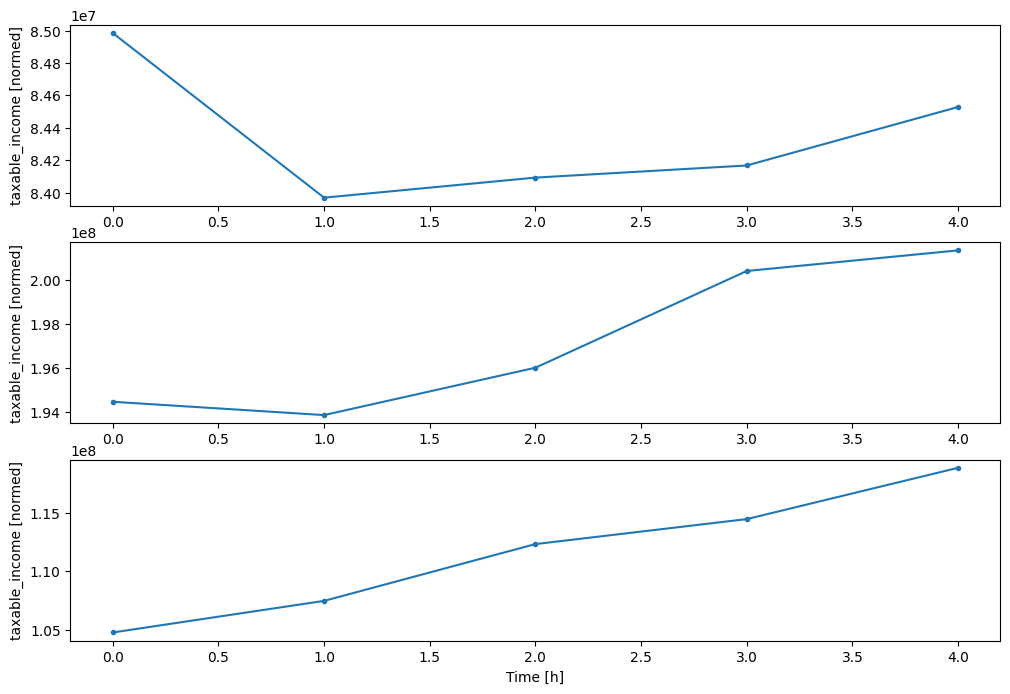

In [11]:
w.example = example_inputs, example_labels
w.plot(plot_col="taxable_income")

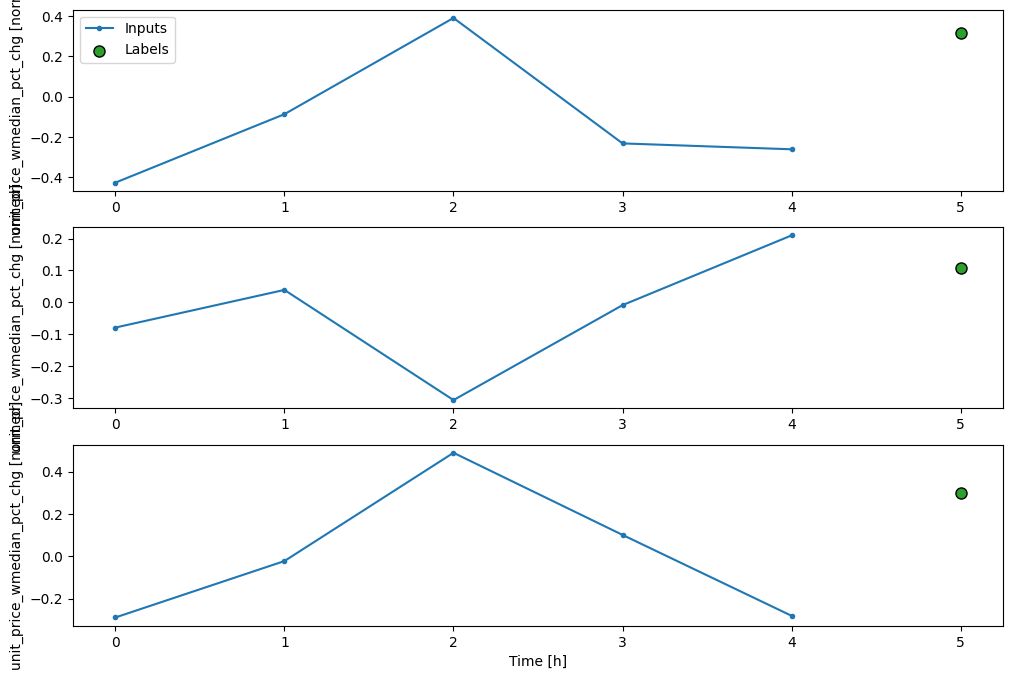

In [12]:
w.plot(plot_col=metric_pct_chg)


In [13]:
windows = []

# have flexible window sizes else you're losing a lot of samples
# or add lpa and plps survey to skip

# for area_code, area_df in df.groupby(by=["area_code"]):
#     max_total_window_size = 6
#     num_years = area_df.shape[0] # rows
#     num_features = area_df.shape[1] # columns
#     print(num_features, num_years)
#     windows += [
#         area_df.iloc[max(0, i - w.total_window_size): i, :].values
#         for i in range(2, num_years)
#     ]
#     break

windows = np.stack([
    area_df.iloc[i: i + w.total_window_size, :].values
    for area_code, area_df in df.groupby(by=["area_code"])
    for i in range(area_df.shape[0] - w.total_window_size + 1)
])

In [14]:
windows.shape

(7063, 6, 12)

In [15]:
# Split data into X and y
X, y = w.split_window(windows)

In [16]:
X.shape, y.shape

((7063, 5, 12), (7063, 1, 1))

In [18]:
len(X)

7063

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader

In [56]:
# no reason why I can't have it inherit all the windowing code above
# I can just pass in the whole dataframe and have the class prepare the rest


class TimeSeriesDataset(Dataset):
    # def __init__(self, X, y):
    #     self.X = X
    #     self.y = y

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # this is brilliant because I don't have to do windowing before hand
        # I can do windowing whenever the get item is called
        # because every year and area should technically be called once
        # so once an idx is called, I get the row
        # then I get the year and area code
        # then I group the area code and get the window for that that ends at that year
        # if year == 2020, then window is [2015, 2016, 2017, 2018, 2019] and y is return in 2020
        # if year == 2007. then window is [2006] -> 2007
        # need to better handle edge cases but I can do that in the transform function
        # can use torch.rand_like for this
        # e.g. [na, na, na, na, 2006] -> 2007
        # this would however, be inefficient

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {
            "window": self.X[idx],
            "target": self.y[idx].squeeze(),  # or maybe reshape(1) to get just the target value
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        window, target = sample["window"], sample["target"]
        return {"window": torch.from_numpy(window), "target": torch.from_numpy(target)}

In [57]:
time_series_dataset = TimeSeriesDataset(X, y)

for i, sample in enumerate(time_series_dataset):
    print(i, sample["window"].shape, sample["target"].shape, sample["target"])
    if i == 3:
        break

0 (5, 12) () 0.0166598107774575
1 (5, 12) () 0.0961085405885155
2 (5, 12) () 0.0358320042530566
3 (5, 12) () -0.0051756366897534


In [58]:
transformed_dataset = TimeSeriesDataset(X, y, transform=ToTensor())

In [59]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=False, num_workers=0)

In [61]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['window'].size(),
          sample_batched['target'].size())

0 torch.Size([4, 5, 12]) torch.Size([4])
1 torch.Size([4, 5, 12]) torch.Size([4])
2 torch.Size([4, 5, 12]) torch.Size([4])
3 torch.Size([4, 5, 12]) torch.Size([4])
4 torch.Size([4, 5, 12]) torch.Size([4])
5 torch.Size([4, 5, 12]) torch.Size([4])
6 torch.Size([4, 5, 12]) torch.Size([4])
7 torch.Size([4, 5, 12]) torch.Size([4])
8 torch.Size([4, 5, 12]) torch.Size([4])
9 torch.Size([4, 5, 12]) torch.Size([4])
10 torch.Size([4, 5, 12]) torch.Size([4])
11 torch.Size([4, 5, 12]) torch.Size([4])
12 torch.Size([4, 5, 12]) torch.Size([4])
13 torch.Size([4, 5, 12]) torch.Size([4])
14 torch.Size([4, 5, 12]) torch.Size([4])
15 torch.Size([4, 5, 12]) torch.Size([4])
16 torch.Size([4, 5, 12]) torch.Size([4])
17 torch.Size([4, 5, 12]) torch.Size([4])
18 torch.Size([4, 5, 12]) torch.Size([4])
19 torch.Size([4, 5, 12]) torch.Size([4])
20 torch.Size([4, 5, 12]) torch.Size([4])
21 torch.Size([4, 5, 12]) torch.Size([4])
22 torch.Size([4, 5, 12]) torch.Size([4])
23 torch.Size([4, 5, 12]) torch.Size([4])
24

In [64]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [70]:
pd.DataFrame(np.random.randn(5, 4)).tail(2)

,0,1,2,3
3,2.482250,1.248958,1.238613,0.101594
4,1.829795,2.997767,-1.585595,-0.513959
